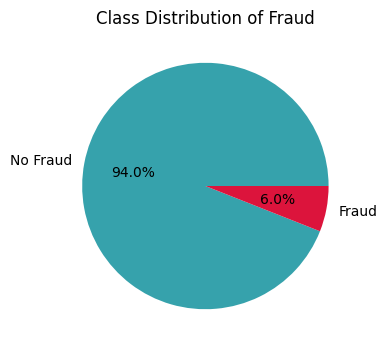

Loading data from: C:\VS CODE\[Dataset] carclaims.csv
Rows: 15420

--- Splitting data ---
Training model...
Done training.
Threshold metrics saved to C:\VS CODE\threshold_metrics.csv
Cost-by-threshold table saved to C:\VS CODE\cost_table_by_threshold.csv
False Negatives at threshold: 350
Deterministic total FN loss: 1386227.475

Monte-Carlo summary:
 num_false_negatives  deterministic_total_loss      mc_mean    mc_median       mc_p10       mc_p90
                 350               1386227.475 1.385849e+06 1.385768e+06 1.361431e+06 1.410679e+06

Saved outputs to: C:\VS CODE


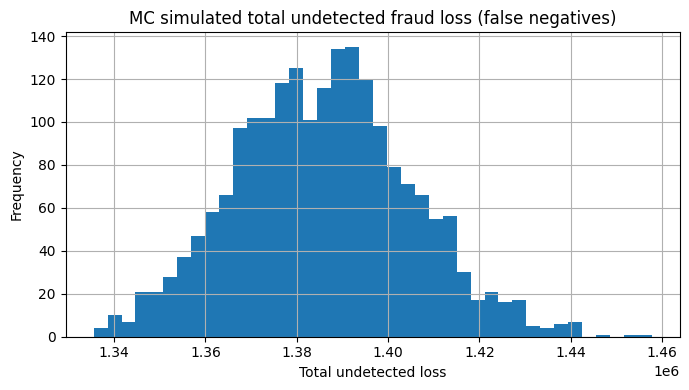


Confusion Matrix (Threshold 0.20):
Predicted:   No Fraud | Fraud
Actual No Fraud: 2510   | 389
Actual Fraud:    91   | 94

Classification Report:
              precision    recall  f1-score   support

No Fraud (0)       0.97      0.87      0.91      2899
   Fraud (1)       0.19      0.51      0.28       185

    accuracy                           0.84      3084
   macro avg       0.58      0.69      0.60      3084
weighted avg       0.92      0.84      0.87      3084



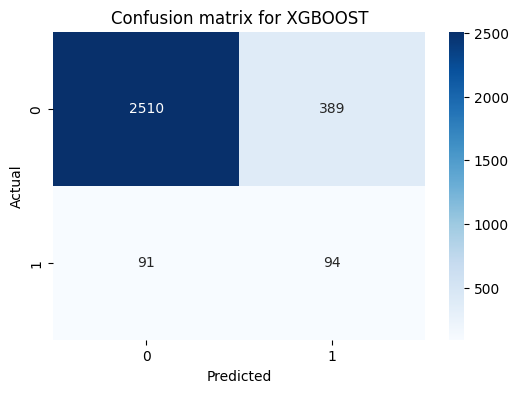

True Positive Rate(TPR):50.81%
False Negative Rate(FNR):49.19%
True Negative Rate(TNR):86.58%
False Positive Rate(FPR):13.42%

Top XGBoost features:
                         feature  importance
            BasePolicy_Liability    0.111269
    PolicyType_Sedan - Liability    0.109695
               Fault_Third Party    0.102083
             Fault_Policy Holder    0.060172
           VehicleCategory_Sport    0.037072
AddressChange-Claim_2 to 3 years    0.029169
        NumberOfSuppliments_none    0.027313
    PolicyType_Sedan - Collision    0.023155
                      Sex_Female    0.021766
                        Sex_Male    0.018640
                       Month_Nov    0.017076
               DayOfWeek_Tuesday    0.016609
         DayOfWeekClaimed_Monday    0.016391
 NumberOfSuppliments_more than 5    0.015555
                    Make_Pontiac    0.015200
       DayOfWeekClaimed_Thursday    0.014791
                    DriverRating    0.013801
        DayOfWeekClaimed_Tuesday    0.013

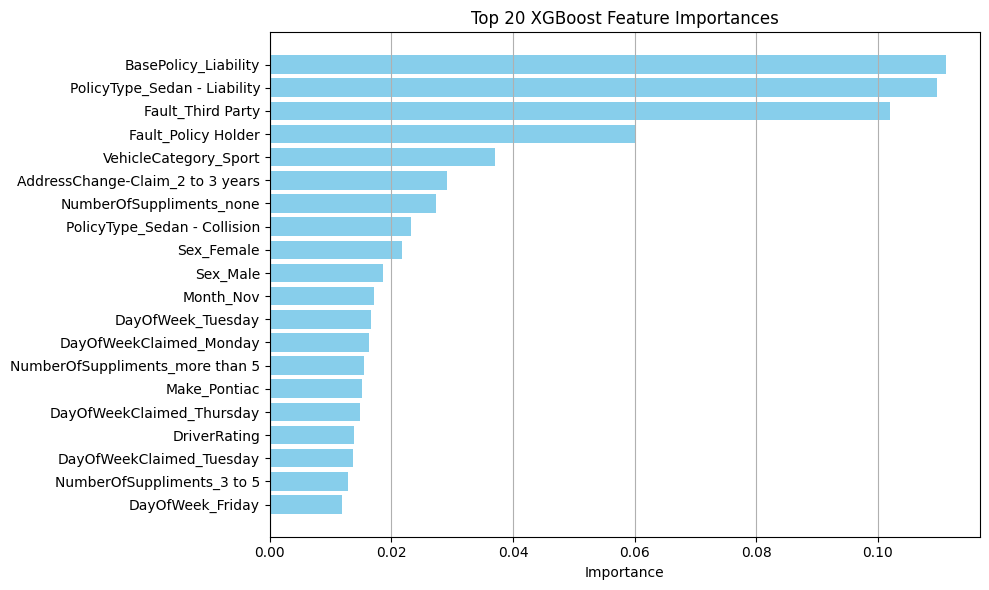

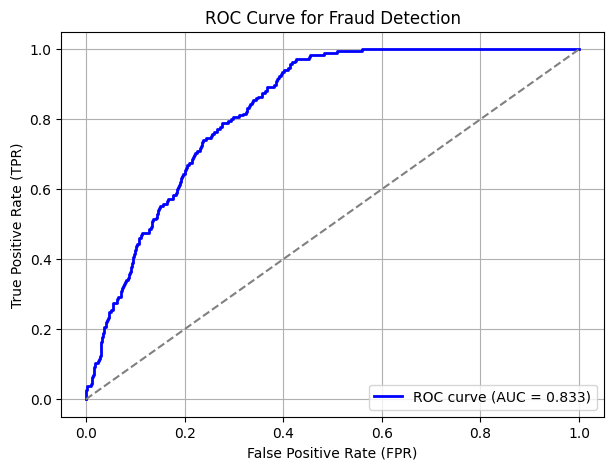

    FraudRiskScore  FraudPredicted
0         0.024072               0
1         0.271105               1
2         0.165828               0
3         0.009778               0
4         0.009305               0
5         0.009075               0
6         0.014501               0
7         0.191892               0
8         0.111780               0
9         0.151441               0
10        0.496450               1
11        0.017382               0
12        0.020974               0
13        0.010833               0
14        0.017899               0
15        0.016731               0
16        0.314521               1
17        0.011439               0
18        0.016573               0
19        0.015750               0
      Month  WeekOfMonth  DayOfWeek       Make AccidentArea DayOfWeekClaimed  \
8922    Jul            1   Thursday  Chevrolet        Urban           Friday   
4274    Nov            2     Sunday     Toyota        Urban           Monday   
3408    Dec            4 

In [33]:
# fraud_model_rewrite.py
"""
Rewritten end-to-end fraud modeling script:
- Preprocessing -> encode -> SMOTE (optional) -> XGBoost training
- Threshold grid evaluation, cost table, Monte-Carlo FN simulation
- Saves CSV outputs similar to original script
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, roc_curve
)
import seaborn as sns
# ---------------- CONFIG ----------------
DATA_PATH = r"C:\VS CODE\[Dataset] carclaims.csv"   # change if needed
OUT_DIR = r"C:\VS CODE"
OUT_CSV = os.path.join(OUT_DIR, "claims_with_risk_scores_and_losses.csv")
COST_CSV = os.path.join(OUT_DIR, "cost_table_by_threshold.csv")
THR_CSV  = os.path.join(OUT_DIR, "threshold_metrics.csv")
RISK_CSV = os.path.join(OUT_DIR, "claim_risk_scores.csv")
FN_SIM_CSV = os.path.join(OUT_DIR, "false_negative_loss_simulation.csv")
df = pd.read_csv(DATA_PATH)
RANDOM_STATE = 42
CHOSEN_THRESHOLD = 0.20    # user-chosen threshold (0-1)
USE_SMOTE = True           # If False, use class weights instead
VERBOSE = True
plt.figure(figsize=(4,4))
plt.pie(df['FraudFound'].value_counts(), labels=['No Fraud', 'Fraud'], autopct='%.1f%%', colors=['#36a2ac', 'crimson'])
plt.title("Class Distribution of Fraud")
plt.show()
# ---------------- Helpers ----------------
def extract_first_int(x, default=np.nan):
    try:
        if pd.isna(x): return default
        s = str(x)
        m = re.search(r'(\d+)', s)
        if m:
            return int(m.group(1))
        return default
    except:
        return default

def safe_get(df, col, default=None):
    return df[col] if col in df.columns else pd.Series([default]*len(df), index=df.index)

def ensure_outdir(path):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# ---------------- Load ----------------
print("Loading data from:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Rows:", len(df))

# ---------------- Label ----------------
if 'FraudFound' not in df.columns:
    raise RuntimeError("Column 'FraudFound' not found in dataset.")
df['_label'] = df['FraudFound'].map(lambda x: 1 if str(x).strip().lower() in ('1','yes','true','y','fraud','fraudulent') else 0)

# ---------------- Estimated loss (proxy) ----------------
df['VehiclePrice'] = pd.to_numeric(safe_get(df, 'VehiclePrice'), errors='coerce')
median_price = df['VehiclePrice'].median() if df['VehiclePrice'].notna().any() else 10000.0
df['VehiclePrice'] = df['VehiclePrice'].fillna(median_price)
df['BaseRepairCost'] = df['VehiclePrice'] * 0.25

category_mult = {'Sedan':1.0,'Sport':1.4,'Utility':1.2,'SUV':1.3,'Van':1.1,'Truck':1.2,'Luxury':1.7}
df['CatMult'] = safe_get(df, 'VehicleCategory').map(category_mult).fillna(1.0)

df['AreaMult'] = safe_get(df, 'AccidentArea').apply(lambda x: 1.2 if isinstance(x, str) and 'urban' in x.lower() else 1.0).fillna(1.0)

df['PoliceReportFiled'] = safe_get(df, 'PoliceReportFiled').astype(str).fillna('No')
df['PoliceMult'] = df['PoliceReportFiled'].apply(lambda x: 1.3 if str(x).strip().lower() in ['yes','y','1','true'] else 1.0)
df['WitnessPresent'] = safe_get(df, 'WitnessPresent').astype(str).fillna('No')
df['WitnessMult'] = df['WitnessPresent'].apply(lambda x: 1.1 if str(x).strip().lower() in ['yes','y','1','true'] else 1.0)

df['PastNumberOfClaims'] = pd.to_numeric(safe_get(df, 'PastNumberOfClaims'), errors='coerce').fillna(0)
df['PastClaimsMult'] = 1 + (df['PastNumberOfClaims'] * 0.05)

def parse_supp(x):
    try:
        if pd.isna(x): return 0
        s = str(x).strip().lower()
        if s in ('none','0','na','n/a'): return 0
        if 'more' in s: return 6
        for token in s.split():
            if token.isdigit(): return int(token)
        return 0
    except:
        return 0

df['NumSupp'] = safe_get(df, 'NumberOfSuppliments').apply(parse_supp)
supplement_cost = 400.0
df['SuppCost'] = df['NumSupp'] * supplement_cost

df['Deductible'] = pd.to_numeric(safe_get(df, 'Deductible'), errors='coerce').fillna(0.0)

if 'AgeOfVehicle' in df.columns:
    df['AgeOfVehicle_num'] = df['AgeOfVehicle'].apply(lambda x: extract_first_int(x, default=np.nan))
    df['AgeOfVehicle_num'] = pd.to_numeric(df['AgeOfVehicle_num'], errors='coerce')
    median_aov = df['AgeOfVehicle_num'].median() if df['AgeOfVehicle_num'].notna().any() else 5.0
    df['AgeOfVehicle'] = df['AgeOfVehicle_num'].fillna(median_aov)
else:
    df['AgeOfVehicle'] = 5.0

df['VehicleAgeMult'] = np.where(df['AgeOfVehicle']<=3,1.0, np.where(df['AgeOfVehicle']<=10,1.05,1.1))

df['Estimated_Loss'] = (
    df['BaseRepairCost'] * df['CatMult'] * df['AreaMult'] *
    df['PoliceMult'] * df['WitnessMult'] * df['PastClaimsMult'] * df['VehicleAgeMult']
) + df['SuppCost'] - df['Deductible']
df['Estimated_Loss'] = df['Estimated_Loss'].clip(lower=0.0)

# ---------------- Features ----------------
candidate_features = [
    'Month','WeekOfMonth','DayOfWeek','Make','AccidentArea','DayOfWeekClaimed','MonthClaimed','WeekOfMonthClaimed',
    'Sex','MaritalStatus','Age','Fault','PolicyType','VehicleCategory','RepNumber','Deductible','DriverRating',
    'Days:Policy-Accident','Days:Policy-Claim','PastNumberOfClaims','AgeOfVehicle','AgeOfPolicyHolder',
    'PoliceReportFiled','WitnessPresent','AgentType','NumberOfSuppliments','AddressChange-Claim','NumberOfCars','Year','BasePolicy'
]
X_cols = [c for c in candidate_features if c in df.columns]
if len(X_cols) == 0:
    raise RuntimeError("No features found - check your column names.")
X = df[X_cols].copy()
y = df['_label'].astype(int)

# Separate numeric and categorical
numeric_cols = [c for c in X_cols if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X_cols if c not in numeric_cols]

# Convert categorical to strings (preserve NaN)
for c in categorical_cols:
    X[c] = X[c].where(~X[c].isnull(), None)
    X[c] = X[c].astype('object').apply(lambda x: str(x) if x is not None else np.nan)

# ---------------- Preprocessor ----------------
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='__missing__')),
                                   ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_cols),
                                  ('cat', categorical_transformer, categorical_cols)],
                                 remainder='drop')

# ---------------- Model (conservative XGBoost) ----------------
def build_xgb(scale_pos_weight=1.0):
    return XGBClassifier(
        n_estimators=800,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        gamma=2,
        reg_alpha=5,
        reg_lambda=5,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        random_state=RANDOM_STATE,
        verbosity=0
    )


# ---------------- Train / Evaluate ----------------
print("\n--- Splitting data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)


# -------------------- PREPROCESSOR --------------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__missing__')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Fit ONLY on training data (NO LEAKAGE)
preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

# -------------------- OPTIONAL SMOTE --------------------
from imblearn.over_sampling import SMOTE

USE_SMOTE = True

if USE_SMOTE:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_enc, y_train)
else:
    X_train_res, y_train_res = X_train_enc, y_train

# Compute correct scale_pos_weight
neg = (y_train_res == 0).sum()
pos = (y_train_res == 1).sum()
scale_pos_weight = neg / pos

# -------------------- MODEL: XGBoost --------------------
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=6,
    gamma=5,
    reg_alpha=8,
    reg_lambda=8,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42,
    use_label_encoder=False,
    verbosity=0
)

print("Training model...")
model.fit(X_train_res, y_train_res)

# -------------------- PROBABILITY PREDICTIONS --------------------
y_proba_test = model.predict_proba(X_test_enc)[:, 1]
y_pred_test = model.predict(X_test_enc)

print("Done training.")


# Evaluate across a threshold grid
thr_grid = np.linspace(0.01, 0.99, 99)
metrics = []
for t in thr_grid:
    y_pred = (y_proba_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # map false negatives back to original df indices (global)
    fn_positions = [i for i, (yt, yp) in enumerate(zip(y_test.values, y_pred)) if int(yt)==1 and int(yp)==0]
    fn_global_idx = X_test.index[fn_positions] if len(fn_positions) > 0 else []
    amount_fn = df.loc[fn_global_idx, 'Estimated_Loss'].sum() if len(fn_global_idx) > 0 else 0.0
    metrics.append({'threshold': float(t), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp), 'amount_fn': float(amount_fn)})

metrics_df = pd.DataFrame(metrics)
ensure_outdir(THR_CSV)
metrics_df.to_csv(THR_CSV, index=False)
print(f"Threshold metrics saved to {THR_CSV}")

# Save cost-by-threshold
investigation_cost = 200.0
recovery_rate = 0.6
cost_rows = []
y_test_vals = y_test.reset_index(drop=True)
for row in metrics:
    t = row['threshold']; fn = row['fn']; fp = row['fp']; tp = row['tp']; tn = row['tn']
    flagged = tp + fp
    y_pred = (y_proba_test >= t).astype(int)
    tp_positions = [i for i, (yt, yp) in enumerate(zip(y_test_vals, y_pred)) if int(yt)==1 and int(yp)==1]
    tp_global_idx = X_test.index[tp_positions] if len(tp_positions) > 0 else []
    amount_tp = df.loc[tp_global_idx, 'Estimated_Loss'].sum() if len(tp_global_idx) > 0 else 0.0
    investigation_total = flagged * investigation_cost
    expected_recovery = amount_tp * recovery_rate
    undetected_loss = row['amount_fn']
    net_cost = undetected_loss + investigation_total - expected_recovery
    cost_rows.append({'threshold': t, 'fn': fn, 'fp': fp, 'tp': tp, 'tn': tn,
                      'amount_fn': undetected_loss, 'amount_tp': amount_tp,
                      'flagged': flagged, 'investigation_total': investigation_total,
                      'expected_recovery': expected_recovery, 'net_cost': net_cost})
cost_df = pd.DataFrame(cost_rows)
ensure_outdir(COST_CSV)
cost_df.to_csv(COST_CSV, index=False)
print(f"Cost-by-threshold table saved to {COST_CSV}")

# ---------------- Apply chosen threshold to full data and generate risk table ----------------
# Score entire dataset (use preprocessor + model)
X_full_enc = preprocessor.transform(X)
df['fraud_risk_score'] = model.predict_proba(X_full_enc)[:,1]
df['pred_chosen'] = (df['fraud_risk_score'] >= CHOSEN_THRESHOLD).astype(int)

# False negatives at chosen threshold (global)
fn_df = df[(df['_label'] == 1) & (df['pred_chosen'] == 0)].copy()
n_fn = len(fn_df)
print("False Negatives at threshold:", n_fn)
total_fn_loss = float(fn_df['Estimated_Loss'].sum())
print("Deterministic total FN loss:", total_fn_loss)

# Monte-Carlo simulation for FN loss
rel_sigma = 0.25
n_sim = 2000
rng = np.random.default_rng(RANDOM_STATE)
mc_totals = np.zeros(n_sim) if n_fn > 0 else np.zeros(n_sim)
if n_fn > 0:
    fn_losses = fn_df['Estimated_Loss'].values
    for i in range(n_sim):
        samples = []
        for m in fn_losses:
            if m <= 0:
                samples.append(0.0)
            else:
                sigma = np.sqrt(np.log(1 + rel_sigma**2))
                mu = np.log(m) - 0.5 * sigma**2
                sampled = rng.lognormal(mean=mu, sigma=sigma)
                samples.append(sampled)
        mc_totals[i] = np.sum(samples)

mc_mean = float(np.mean(mc_totals))
mc_median = float(np.median(mc_totals))
mc_p10 = float(np.percentile(mc_totals, 10))
mc_p90 = float(np.percentile(mc_totals, 90))
sim_summary = pd.DataFrame([{
    "num_false_negatives": n_fn,
    "deterministic_total_loss": total_fn_loss,
    "mc_mean": mc_mean,
    "mc_median": mc_median,
    "mc_p10": mc_p10,
    "mc_p90": mc_p90
}])
ensure_outdir(FN_SIM_CSV)
sim_summary.to_csv(FN_SIM_CSV, index=False)
print("\nMonte-Carlo summary:")
print(sim_summary.to_string(index=False))

# Save outputs
ensure_outdir(OUT_CSV)
df.to_csv(OUT_CSV, index=False)
ensure_outdir(RISK_CSV)
final_risk = pd.DataFrame({
    'index': df.index,
    "PredictedFraudProbability": df['fraud_risk_score'].values,
    "ActualFraud": df['_label'].values,
    "Estimated_Loss": df['Estimated_Loss'].values
})
final_risk.to_csv(RISK_CSV, index=False)
print("\nSaved outputs to:", OUT_DIR)

# Plot MC totals if available
if n_fn > 0:
    plt.figure(figsize=(7,4))
    plt.hist(mc_totals, bins=40)
    plt.title("MC simulated total undetected fraud loss (false negatives)")
    plt.xlabel("Total undetected loss")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------- Final test-set classification report & confusion matrix at chosen threshold ----------------
probs_test = y_proba_test  # from above predictions on X_test_enc
y_pred_test = (probs_test >= CHOSEN_THRESHOLD).astype(int)
print("\nConfusion Matrix (Threshold {:.2f}):".format(CHOSEN_THRESHOLD))
cm = confusion_matrix(y_test, y_pred_test)
print("Predicted:   No Fraud | Fraud")
print(f"Actual No Fraud: {cm[0,0]}   | {cm[0,1]}")
print(f"Actual Fraud:    {cm[1,0]}   | {cm[1,1]}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['No Fraud (0)', 'Fraud (1)']))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix for XGBOOST")
plt.show()


tn, fp, fn, tp = cm.ravel() #Unpack the confusion matrix 
tpr = tp/ (tp+fn)
fpr = fp/(tn+fp)
fnr = fn/(tp+fn)
tnr = tn/(tn+fp)
print(f"True Positive Rate(TPR):{tpr*100:.2f}%")
print(f"False Negative Rate(FNR):{fnr*100:.2f}%")
print(f"True Negative Rate(TNR):{tnr*100:.2f}%")
print(f"False Positive Rate(FPR):{fpr*100:.2f}%")
# ---------------- Feature importance (XGBoost) ----------------
# ---------------- Feature importance (XGBoost) ----------------
try:
    # Get numeric feature names
    numeric_features = numeric_cols
    
    # Get categorical feature names after one-hot encoding
    cat_features = []
    if categorical_cols:
        cat_transformer = preprocessor.named_transformers_['cat']['onehot']
        cat_names = cat_transformer.get_feature_names_out(categorical_cols)
        cat_features = list(cat_names)
    
    # Combine
    feature_names = numeric_features + cat_features
    
    # Extract importances
    importances = model.feature_importances_
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
    
    print("\nTop XGBoost features:")
    print(imp_df.head(20).to_string(index=False))
    
    # Plot
    top_n = 20
    plt.figure(figsize=(10,6))
    plt.barh(imp_df['feature'].head(top_n)[::-1], imp_df['importance'].head(top_n)[::-1], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 20 XGBoost Feature Importances')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not extract feature importances:", e)

fraud_prob = model.predict_proba(X_test_enc)[:, 1]  # ✅
   # Probability of fraud = class 1

# Attach to dataframe
def compute_fraud_risk(df_input, model, preprocessor, threshold=0.5):
    """
    Compute fraud risk scores for any input dataframe.
    
    Parameters:
    - df_input: pd.DataFrame, raw input data
    - model: trained XGBClassifier
    - preprocessor: fitted ColumnTransformer (numeric + categorical)
    - threshold: float, binary prediction cutoff
    
    Returns:
    - df_result: pd.DataFrame, original data + 'FraudRiskScore' and 'FraudPredicted'
    """
    # Copy to avoid modifying original df
    df_result = df_input.copy()
    
    # Ensure only columns used in training
    X_cols = preprocessor.feature_names_in_  # columns used in preprocessor
    X = df_result[X_cols].copy()
    
    # Preprocess
    X_enc = preprocessor.transform(X)
    
    # Predict probabilities
    fraud_score = model.predict_proba(X_enc)[:, 1]
    
    # Attach scores
    df_result['FraudRiskScore'] = fraud_score
    df_result['FraudPredicted'] = (fraud_score >= threshold).astype(int)
    
    return df_result
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Fraud Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# -----------------------------
# 7. Show results
# -----------------------------
pd.set_option('display.max_rows', 20)
df_with_risk = compute_fraud_risk(df, model, preprocessor, threshold=0.2)
print(df_with_risk[['FraudRiskScore', 'FraudPredicted']].head(20))
print(df_results.head())
print("\nDone.")
